# Segmenting and Clustering Neighborhoods in Toronto
This notebook is used for the pear-graded assignment of the data science capstone course, week 3.

there are tree sub assignments to do. they will be marked by titles for quick reference:
    - assignment 1
    - assignment 2
    - assignment 3

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [25]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [2]:
#update conda if needed
#!conda update conda --yes # uncomment this line if the package is not yet installed
#!conda update conda-build --yes # uncomment this line if the package is not yet installed

#import geopy and folium
!conda install -c conda-forge geopy --yes # uncomment this line if the package is not yet installed

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if the package is not yet installed

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/nbuser/anaconda3_420:

The following NEW packages will be INSTALLED:

    _libgcc_mutex: 0.1-main         conda-forge
    geographiclib: 1.50-py_0        conda-forge
    geopy:         1.21.0-py_0      conda-forge
    readline:      7.0-ha6073c6_4              

The following packages will be UPDATED:

    conda:         4.3.31-py35_0                --> 4.5.11-py35_0        conda-forge
    pycosat:       0.6.1-py35_1                 --> 0.6.3-py35h470a237_1 conda-forge

The following packages will be SUPERSEDED by a higher-priority channel:

    conda-env:     2.6.0-h36134e3_1             --> 2.6.0-1              conda-forge

_libgcc_mutex- 100% |################################| Time: 0:00:00   2.69 MB/s
conda-env-2.6. 100% |################################| Time: 0:00:00   2.96 MB/s
readline-7.0-h 100% |################################| Time: 0:00:00  12.47 MB

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

## assignment 1
In this assignment we wil scrape date from the following wikipedia page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and insert it in an pandas dataframe.

In [4]:
#first we need to install the BeautifulSoup package

#!conda install -c anaconda beautifulsoup4 --yes # uncomment this line if the package is not yet installed

To get the dataframe into pandas we will use beautifulsoup to scrape the website and turn it into a dataframe. 

In [5]:
from bs4 import BeautifulSoup
# Here, we're just importing Beautiful Soup
page_link = 'https://en.m.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# this is the url.
page_response = requests.get(page_link, timeout=5)
# here, we fetch the content from the url, using the requests library
soup = BeautifulSoup(page_response.content, "html.parser")
#we use the html parser to parse the url content and store it in a variable.
table = soup.find_all('table')
df = pd.read_html(str(table), header=0)[0]

Now we got the raw table from the website into a pandas dataframe. the next step is to explore and clean the data.

In [6]:
print(df.shape)
df.head()

(180, 3)


,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [7]:
#first we delete the rows where there is no Borough
# Get names of indexes for which column Borough is 'Not assigned'
indexNames = df[ df['Borough'] == 'Not assigned' ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In the database produced the Neighborhoods are already combined if they have the same Postal code. they are separated bij '/' instead of ',' so this will need to be replaced.

In [8]:
#Replace the ' /' by ','
df['Neighborhood'] = df['Neighborhood'].str.replace(' /',',')
print('Are there any duplicate values in Postal code:', df['Postal code'].duplicated().any())
df.describe()

Are there any duplicate values in Postal code: False


,Postal code,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M4W,North York,Downsview
freq,1,24,4


As shown below there are no cells left in the dataframe with a NaN value.

In [9]:
df.isnull().sum(axis = 0)

Postal code     0
Borough         0
Neighborhood    0
dtype: int64

In [10]:
df.shape

(103, 3)

## Assignment 2
In assignment 2 we are going to add the latlong coordinates of the postal codes.

unfortunatly the geocoder package is not working so the CSV will be used.

In [11]:
#first import the CSV file
Postal_code = pd.read_csv('https://cocl.us/Geospatial_data')
Postal_code.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
#Then we join the two files and check if there are no empty values, the amount of rows are still the same
#and show the head of the dataframe
df_ll = df.join(Postal_code.set_index('Postal Code'), on='Postal code')
print(df_ll.isnull().sum(axis = 0))
print(df_ll.shape)
df_ll.head(10)

Postal code     0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64
(103, 5)


,Postal code,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
8,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
9,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
11,M3B,North York,Don Mills,43.745906,-79.352188
12,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
13,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Assignment 3
In assignment 3 we are going to cluster the Neighborhoods on the basis of the ten most found venues using K-means. Then we are going to plot this on an interactive map.

lets first find the coordinates of Toronto and plot all the neighborhoods on the map of the city.

In [13]:
#find the coordinates of Toronto
address = 'Toronto'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ll['Latitude'], df_ll['Longitude'], df_ll['Borough'], df_ll['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

now that we know that it works we should use the foursquare API to add venue data to our dataframe. lets first initialise the credentials.

In [15]:
CLIENT_ID = '_____' # your Foursquare ID
CLIENT_SECRET = '_____' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Now we create a function that can find the top 100 venues for each Postal code.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(names)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Then we use te function to store the data in a new dataframe.

In [17]:
toronto_venues = getNearbyVenues(names=df_ll['Neighborhood'],
                                   latitudes=df_ll['Latitude'],
                                   longitudes=df_ll['Longitude']
                                  )

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

2                                              Parkwoods
3                                       Victoria Village
4                              Regent Park, Harbourfront
5                       Lawrence Manor, Lawrence Heights
6            Queen's Park, Ontario Provincial Government
8                                       Islington Avenue
9                                         Malvern, Rouge
11                                             Don Mills
12                       Parkview Hill, Woodbine Gardens
13                              Garden District, Ryerson
14                                             Glencairn
17     West Deane Park, Princess Gardens, Martin Grov...
18                Rouge Hill, Port Union, Highland Creek
20                                             Don Mills
21                                      Woodbine Heights
22                                        St. James Town
23                                    Humewood-Cedarvale
26     Eringate, Bloordale Gard

In [18]:
#check the data
print(toronto_venues.shape)
toronto_venues.head()

(2126, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


then we make dummy variables and group the means by neighborhood to make the dataframe ready for K-means analysis.

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [20]:
toronto_onehot.shape

(2126, 262)

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000

Lets create a top 10 list of venues in each neighborhood.

In [28]:
#function to sort on most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(93, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Latin American Restaurant,Breakfast Spot,Lounge,Dance Studio,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Sandwich Place,Skating Rink,Pharmacy,Pub,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Park,Diner,Bridal Shop,Restaurant,Deli / Bodega,Ice Cream Shop,Supermarket
3,Bayview Village,Chinese Restaurant,Café,Japanese Restaurant,Bank,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Restaurant,Coffee Shop,Thai Restaurant,Indian Restaurant,Liquor Store,Pub,Butcher,Café


Here we are going to check what the best number of clusters is voor the K-means analysis

In [23]:
# first we need drop the neighborhood column to perform the analyses.
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

#Then run the K value for 15 times. It will always get closer to zero if K is bigger.
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)


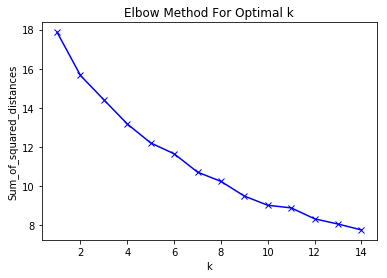

In [26]:
# To find the best K value we look for the knee in the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

although the plot is not very clear. The first elbow is at 5 so we will chose that number for K. Now we are going to create the clusters and plot them on the map.

In [30]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [68]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_ll

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(103, 16)


,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Women's Store,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store
3,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,French Restaurant,Hockey Arena,Pizza Place,Portuguese Restaurant,Women's Store,Dessert Shop,Dance Studio,Deli / Bodega,Department Store
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Performing Arts Venue,Electronics Store,Spa
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Women's Store,Arts & Crafts Store,Furniture / Home Store,Event Space,Miscellaneous Shop,Coffee Shop,Boutique,Gift Shop,Accessories Store
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Diner,College Cafeteria,Beer Bar,Sandwich Place,Burger Joint,Burrito Place,Café,Park


In [69]:
#since there are more postal codes then neighborhood we have rows with cluster value NaN. They have to be droped
toronto_merged = toronto_merged.dropna()
toronto_merged = toronto_merged.reset_index(drop=True)

print(toronto_merged.shape)

#then the type in column Cluster Labels should be changed from float to int
toronto_merged = toronto_merged.astype({'Cluster Labels': 'int64'})
print(toronto_merged.dtypes)

(98, 16)
Postal code                object
Borough                    object
Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object


Finally, let's visualize the resulting clusters

In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters